<a id='top-page'></a>
# Visualize evolving projection topologies during training

### Table of contents

- [**Load the training data**](#load-data)
- [**Generate a low-dimensional projection**](#generate-projection)
- [**Measure nonlinear reconstruction errors on initial and improved projections**](#reconstruction-errors)

***

In [4]:
%run -i imports.py
%matplotlib inline

In [46]:
plot_save_location = '../figures/'
cmap = cmc.lajolla

<a id='load-data'></a>
***

## Load the training data

[Go to the top ↑](#top-page)

In [8]:
data_tag = 'hydrogen-Konnov'

state_space = pd.read_csv('../data/SLF-' + data_tag + '-state-space.csv', sep = ',', header=None).to_numpy()
state_space_sources = pd.read_csv('../data/SLF-' + data_tag + '-state-space-sources.csv', sep = ',', header=None).to_numpy()
state_space_names = pd.read_csv('../data/SLF-' + data_tag + '-state-space-names.csv', sep = ',', header=None).to_numpy().ravel()

(n_observations, n_variables) = np.shape(state_space)

print(state_space_names)

['T' 'H2' 'H' 'O' 'OH' 'H2O' 'O2' 'HO2' 'H2O2']


In [9]:
(n_observations, n_variables) = np.shape(state_space)

<a id='generate-projection'></a>
***

## Generate a low-dimensional projection

[Go to the top ↑](#top-page)

In [15]:
n_components = 2

In [16]:
(input_data, centers, scales) = preprocess.center_scale(state_space, scaling='0to1')
projection_dependent_outputs = state_space_sources / scales

In [17]:
pca = reduction.PCA(state_space, n_components=n_components, scaling='auto')
encoder_weights_init = pca.A[:,0:n_components]

In [18]:
X_projected = np.dot(input_data, encoder_weights_init)
S_X_projected = np.dot(projection_dependent_outputs, encoder_weights_init)

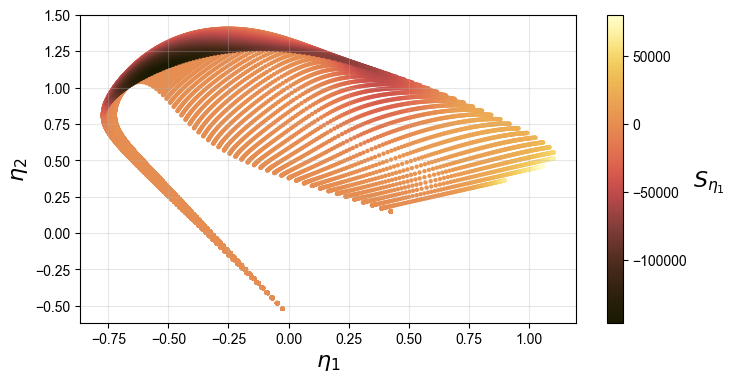

In [19]:
plt = reduction.plot_2d_manifold(X_projected[:,0], 
                                 X_projected[:,1], 
                                 s=10,
                                 color=S_X_projected[:,0], 
                                 color_map=cmap,
                                 colorbar_label='$S_{\eta_1}$',
                                 x_label='$\eta_1$',
                                 y_label='$\eta_2$', 
                                 figure_size=(8,4))

In [20]:
selected_state_variables = [0, 1, 4, 5, 6]

In [21]:
print(state_space_names[selected_state_variables])

['T' 'H2' 'OH' 'H2O' 'O2']


In [22]:
random_seed = 12

In [23]:
activation_decoder = 'tanh'
decoder_interior_architecture = (6,8,9)
optimizer = 'Adam'
learning_rate = 0.001
loss = 'MSE'
batch_size = n_observations
validation_perc = 10

In [24]:
hold_initialization = None
hold_weights = None

In [25]:
n_epochs = 6000

In [26]:
projection = utilities.QoIAwareProjection(input_data, 
                                          n_components=n_components, 
                                          projection_independent_outputs=input_data[:,selected_state_variables],
                                          projection_dependent_outputs=projection_dependent_outputs,
                                          activation_decoder=activation_decoder,
                                          decoder_interior_architecture=decoder_interior_architecture,
                                          encoder_weights_init=encoder_weights_init,
                                          decoder_weights_init=None,
                                          hold_initialization=hold_initialization,
                                          hold_weights=hold_weights,
                                          transformed_projection_dependent_outputs='signed-square-root',
                                          transform_power=0.5,
                                          transform_shift=10**-4,
                                          transform_sign_shift=0,
                                          loss=loss,
                                          optimizer=optimizer,
                                          batch_size=batch_size,
                                          n_epochs=n_epochs,
                                          learning_rate=learning_rate,
                                          validation_perc=validation_perc,
                                          random_seed=random_seed,
                                          verbose=True)

In [27]:
projection.train()

Starting model training...


Decoder outputs are scaled to a -1 to 1 range.
Using 10% of input data as validation data. Model will be trained on 90% of input data.



  0%|                                                  | 0/6000 [00:00<?, ?it/s]/Users/kamilazdybal/anaconda3/envs/latest-stack/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
100%|███████████████████████████████████████| 6000/6000 [02:12<00:00, 45.29it/s]

Time it took: 2.2 minutes.



<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/latest-stack/lib/python3.10/site-packages/matplotlib/pyplot.py'>

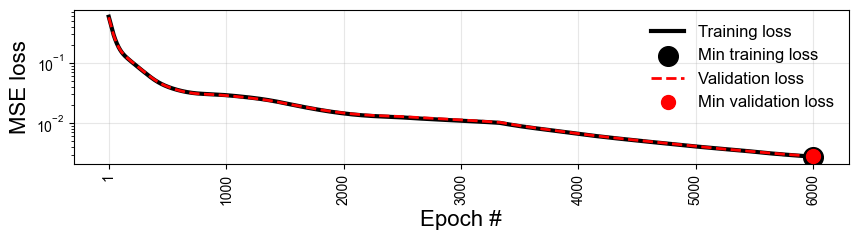

In [28]:
projection.plot_losses(markevery=1000,
                       figure_size=(10, 2))

In [29]:
basis = projection.get_best_basis(method='min-training-loss')

Minimum training loss:		0.0027705447282642126
Minimum training loss at epoch:	6000


In [30]:
X_projected = np.dot(input_data, basis)
S_X_projected = np.dot(projection_dependent_outputs, basis)

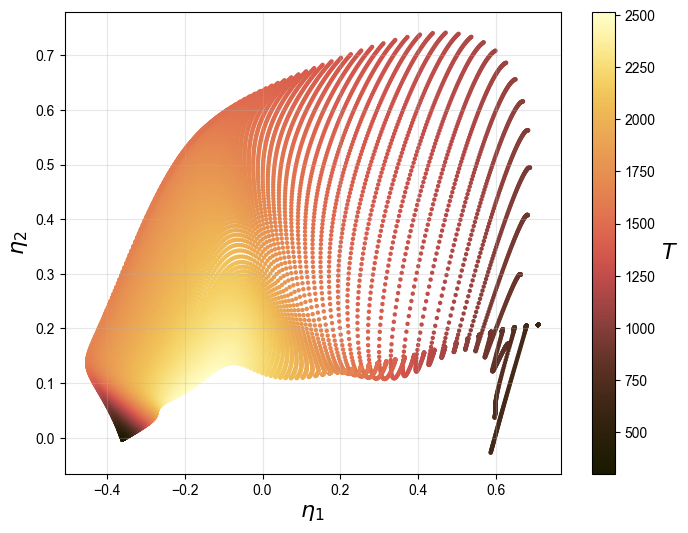

In [31]:
plt = reduction.plot_2d_manifold(X_projected[:,0], 
                                 X_projected[:,1], 
                                 s=10,
                                 color=state_space[:,0], 
                                 color_map=cmap,
                                 colorbar_label='$T$',
                                 x_label='$\eta_1$',
                                 y_label='$\eta_2$', 
                                 figure_size=(8,6))

In [32]:
idx = 4000
X_projected = np.dot(input_data, projection.bases_across_epochs[idx])

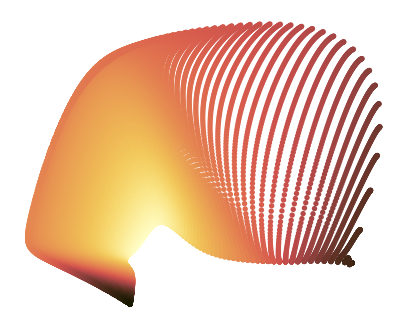

In [33]:
plt = reduction.plot_2d_manifold(X_projected[:,0], 
                                 X_projected[:,1], 
                                 clean=True,
                                 s=15,
                                 color=state_space[:,0], 
                                 color_map=cmap,
                                 figure_size=(5,4))

<a id='reconstruction-errors'></a>
***

## Measure nonlinear reconstruction errors on initial and improved projections

[Go to the top ↑](#top-page)

In [34]:
X_projected_init = np.dot(input_data, encoder_weights_init)

In [35]:
(X_projected_pp, centers_X_AE, scales_X_AE) = preprocess.center_scale(X_projected_init, '0to1')
temperature = state_space[:,0]

In [36]:
model = analysis.KReg(X_projected_pp, temperature[:,None])

In [38]:
temperature_predicted = model.predict(X_projected_pp, bandwidth='nearest_neighbors_isotropic', n_neighbors=100)

In [39]:
NRMSE_test = reconstruction.normalized_root_mean_squared_error(temperature, temperature_predicted, norm='std')
R2_test = reconstruction.coefficient_of_determination(temperature, temperature_predicted)

In [40]:
NRMSE_test

0.21636583635141313

In [41]:
R2_test

0.9531858248599535

In [42]:
error_init = np.abs(temperature_predicted.ravel() - temperature.ravel())

In [44]:
cmap = cmc.vik

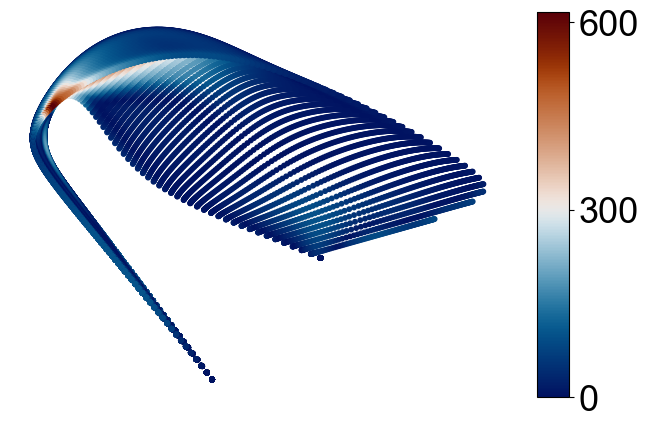

In [45]:
fig = plt.figure(figsize=(8,5))
spec = fig.add_gridspec(ncols=1, nrows=1, width_ratios=[1], height_ratios=[1])

figure = fig.add_subplot(spec[0,0])
scat = plt.scatter(X_projected_init[:,0], X_projected_init[:,1], s=10, c=error_init, cmap=cmap)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(scat, ticks=[0,300,600], aspect=12)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(26)
plt.savefig(plot_save_location + 'initialization-absolute-error.png', dpi=300, bbox_inches='tight')

In [47]:
(X_projected_pp, centers_X_AE, scales_X_AE) = preprocess.center_scale(X_projected, '0to1')
temperature = state_space[:,0]

In [48]:
model = analysis.KReg(X_projected_pp, temperature[:,None])

In [49]:
temperature_predicted = model.predict(X_projected_pp, bandwidth='nearest_neighbors_isotropic', n_neighbors=100)

In [50]:
NRMSE_test = reconstruction.normalized_root_mean_squared_error(temperature, temperature_predicted, norm='std')
R2_test = reconstruction.coefficient_of_determination(temperature, temperature_predicted)

In [51]:
NRMSE_test

0.046076067665581366

In [52]:
R2_test

0.9978769959884768

In [53]:
error = np.abs(temperature_predicted.ravel() - temperature.ravel())

In [55]:
cmap = cmc.vik

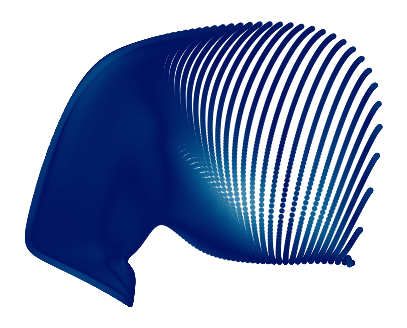

In [56]:
plt = reduction.plot_2d_manifold(X_projected[:,0], 
                                 X_projected[:,1], 
                                 s=15,
                                 clean=True,
                                 color=error, 
                                 color_map=cmap,
                                 colorbar_range=(np.min(error_init), np.max(error_init)),
                                 figure_size=(5,4))

***